In [38]:
import iris
import glob
import warnings
warnings.filterwarnings('ignore')

import pandas
import numpy
import seaborn

In [39]:
%matplotlib inline

## Deviation from pre-industrial interhemispheric OHC distribution

In [34]:
aa_physics = {'CanESM2': 'p4', 'CCSM4': 'p10', 'CSIRO-Mk3-6-0': 'p4',
              'GFDL-CM3': 'p1', 'GISS-E2-H': 'p107', 'GISS-E2-R': 'p107',
              'NorESM1-M': 'p1'}

def get_data(experiment, model):
    """Get the NH and globe data cubes"""

    start_date = iris.time.PartialDateTime(year=1861, month=1, day=1)
    if 'rcp85' in experiment:
        end_date = iris.time.PartialDateTime(year=2100, month=12, day=31)
    else:
        end_date = iris.time.PartialDateTime(year=2005, month=12, day=31)
    time_constraint = iris.Constraint(time=lambda t: start_date <= t.point <= end_date)

    dir_experiment = 'rcp85' if experiment == 'historical-rcp85' else experiment 
    mip = 'r1i1' + aa_physics[model] if experiment == 'historicalMisc' else 'r1i1p1'

    mydir = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/%s/ohc/latest/dedrifted' %(model, dir_experiment, mip)
    
    globe_files = glob.glob('%s/ohc-globe-sum_*.nc' %(mydir))
    nh_files = glob.glob('%s/ohc-nh-sum_*.nc' %(mydir))
    
    assert len(globe_files) == len(nh_files) == 1
    
    globe_cube = iris.load_cube(globe_files[0], 'ocean heat content globe sum' & time_constraint)   
    nh_cube = iris.load_cube(nh_files[0], 'ocean heat content nh sum' & time_constraint)
    
    delta_nh = nh_cube.data[-1] - nh_cube.data[0]
    delta_globe = globe_cube.data[-1] - globe_cube.data[0]
    delta_ratio = delta_nh / delta_globe
    
    mean_nh = nh_cube.data.mean()
    mean_globe = globe_cube.data.mean()
    mean_ratio = mean_nh / mean_globe
    
    result = delta_ratio - mean_ratio
    if delta_globe < 0:
        result = result * -1
    
    return result * 100, mip


columns = ['model', 'mip',  'historicalGHG', 'historicalMisc', 'historical', 'historical-rcp85']

def generate_data_dict(diff, model, experiment, mip):
    """Generate dict that will form a row of a pandas dataframe."""

    data_dict = {'model': model, 'mip': mip}
    for column_label in columns[2:]:
        if column_label == experiment:
            data_dict[column_label] = diff
        else:
            data_dict[column_label] = numpy.nan
    
    return data_dict


In [27]:
for experiment in ['historicalGHG', 'historicalMisc', 'historical', 'historical-rcp85']:
    for model in ['CanESM2', 'CCSM4', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'NorESM1-M']:
        print('%s, %s: %s' %(experiment, model, get_data(experiment, model)[0]))

historicalGHG, CanESM2: 6.53732699568
historicalGHG, CCSM4: 1.20074495555
historicalGHG, CSIRO-Mk3-6-0: 0.348452151026
historicalGHG, GISS-E2-R: -0.575035960339
historicalGHG, NorESM1-M: 3.48698711813
historicalMisc, CanESM2: -13.6784258086
historicalMisc, CCSM4: -16.7158304319
historicalMisc, CSIRO-Mk3-6-0: -0.399113654509
historicalMisc, GISS-E2-R: -8.14011342473
historicalMisc, NorESM1-M: -15.9014578061
historical, CanESM2: -0.173420580159
historical, CCSM4: -0.293199077156
historical, CSIRO-Mk3-6-0: 10.4229048922
historical, GISS-E2-R: 1.82097907027
historical, NorESM1-M: -5.82570851349
historical-rcp85, CanESM2: 5.42150933713
historical-rcp85, CCSM4: 0.0440829994542
historical-rcp85, CSIRO-Mk3-6-0: 2.12421063339
historical-rcp85, GISS-E2-R: 0.794644309049
historical-rcp85, NorESM1-M: 3.77908064185


In [36]:
data_list = []
for experiment in ['historicalGHG', 'historicalMisc', 'historical', 'historical-rcp85']:
    for model in ['CanESM2', 'CCSM4', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'NorESM1-M']:
        diff, mip = get_data(experiment, model)
        data_list.append(generate_data_dict(diff, model, experiment, mip))
data_df = pandas.DataFrame(data_list) 

In [37]:
data_df

,historical,historical-rcp85,historicalGHG,historicalMisc,mip,model
0,NaN,NaN,6.537327,NaN,r1i1p1,CanESM2
1,NaN,NaN,1.200745,NaN,r1i1p1,CCSM4
2,NaN,NaN,0.348452,NaN,r1i1p1,CSIRO-Mk3-6-0
3,NaN,NaN,-0.575036,NaN,r1i1p1,GISS-E2-R
4,NaN,NaN,3.486987,NaN,r1i1p1,NorESM1-M
5,NaN,NaN,NaN,-13.678426,r1i1p4,CanESM2
6,NaN,NaN,NaN,-16.715830,r1i1p10,CCSM4
7,NaN,NaN,NaN,-0.399114,r1i1p4,CSIRO-Mk3-6-0
8,NaN,NaN,NaN,-8.140113,r1i1p107,GISS-E2-R
9,NaN,NaN,NaN,-15.901458,r1i1p1,NorESM1-M


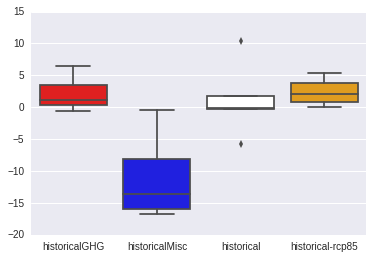

In [41]:
seaborn.boxplot(data=data_df[columns], orient="v", palette=['red', 'blue', 'white', 'orange'])

# Change in OHC fraction